# Assignment V: GitHub and the ticketmaster.com API

## General

GitHub repository: https://github.com/Borschu/Assignment_05

Import packages:

In [86]:
import numpy as np
import pandas as pd
import requests
import time

import sys
!{sys.executable} -m pip install geopandas

     ---------------------------------------- 1.1/1.1 MB 6.7 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 12.4 MB/s eta 0:00:00
     --------------------------------------- 21.7/21.7 MB 24.2 MB/s eta 0:00:00
     ---------------------------------------- 4.8/4.8 MB 28.1 MB/s eta 0:00:00


## Setting up a new GitHub repository

see link above

## Getting to know the API

### (5)

Rate limits:
- 5000 API calls per day
- 5 requests per second
- you can only retrieve the 1000 th item (size * page < 1000)


### (6)

In [22]:
# create connection to API key
#with open(r"C:\Users\schur\OneDrive\Dokumente\Studium\Data Science Master Tübingen\1. Semester\Data Science Project Management\Assignment\key_assignment_5_python.py") as script:
#    exec(script.readline())

with open("C:/Users/schur/OneDrive/Dokumente/Studium/Data Science Master Tübingen/1. Semester/Data Science Project Management/Assignment/key_assignment_5_python.py") as script:
  exec(script.readline())


## Interacting with the API - the basics

### (7)

In [21]:
# create content for venue = Germany
con_ven_ger = requests.get("https://app.ticketmaster.com/discovery/v2/venues",
                          params = {"apikey": ticketmaster_key, "countryCode": "DE"}).json()

# print content
print(con_ven_ger)

{'_embedded': {'venues': [{'name': 'Gruenspan', 'type': 'venue', 'id': 'KovZpZAneakA', 'test': False, 'url': 'http://www.ticketmaster.de/venue/287155', 'locale': 'en-de', 'images': [{'ratio': '16_9', 'url': 'https://s1.ticketm.net/dbimages/2057v.', 'width': 205, 'height': 115, 'fallback': False}], 'postalCode': '22767', 'timezone': 'Europe/Berlin', 'city': {'name': 'Hamburg'}, 'country': {'name': 'Germany', 'countryCode': 'DE'}, 'address': {'line1': 'Grosse Freiheit 58'}, 'location': {'longitude': '9.958075', 'latitude': '53.551885'}, 'markets': [{'name': 'Germany', 'id': '210'}], 'dmas': [{'id': 610}], 'boxOfficeInfo': {'phoneNumberDetail': 'Gruenspan Große Freiheit 58 22767 Hamburg Tel: 040-313616 mail: info@gruenspan.de web: www.gruenspan.de'}, 'upcomingEvents': {'_total': 2, 'mfx-de': 2, '_filtered': 0}, 'ada': {'adaPhones': '+49.(0)1805 - 969 0000 (14 Ct./Min.)', 'adaCustomCopy': 'Sollten Sie besondere Sitzplatzwünsche haben, prüfen Sie bitte die Informationsseite des Veranstaltun

### (8)

In [71]:
# define size of page
size = con_ven_ger['page']['size']

# create empty vectors for all characteristics
name = [None]*size
city = [None]*size
postalCode = [None]*size
address = [None]*size
url = [None]*size
longitude = [None]*size
latitude = [None]*size

# for loop over all list entries for every characteristic of the venue
for i in range(size):
    # If a list element doesnt exist a key error occurs and the loop stops.
    # To avoid this the try-except-structure is built
    # if a KeyError occurs the value is codes as NaN
    try:
        name[i] = con_ven_ger['_embedded']['venues'][i]["name"]
    except KeyError:
        name[i] = np.nan
    try:
        city[i] = con_ven_ger['_embedded']['venues'][i]["city"]['name']
    except KeyError:
        city[i] = np.nan
    try:
        postalCode[i] = con_ven_ger['_embedded']['venues'][i]["postalCode"]
    except KeyError:
        postalCode[i] = np.nan
    try:
        address[i] = con_ven_ger['_embedded']['venues'][i]["address"]['line1']
    except KeyError:
        address[i] = np.nan
    try:
        url[i] = con_ven_ger['_embedded']['venues'][i]["url"]
    except KeyError:
        url[i] = np.nan
    try:
        longitude[i] = con_ven_ger['_embedded']['venues'][i]["location"]["longitude"]
    except KeyError:
        longitude[i] = np.nan
    try:
        latitude[i] = con_ven_ger['_embedded']['venues'][i]["location"]["latitude"]
    except KeyError:
        latitude[i] = np.nan
    
# create dataframe based on the previous created lists
df_venue_ger = pd.DataFrame({"name": name,
                           "city": city,
                           "postalCode": postalCode,
                           "address": address,
                           "url": url,
                           "longitude": longitude,
                           "latitude": latitude})

# print dataframe
print(df_venue_ger)


                             name             city postalCode  \
0                       Gruenspan          Hamburg      22767   
1               Huxleys Neue Welt           Berlin      10967   
2                   Virtual Event        Worldwide        NaN   
3           Ev. St. Jacobi Kirche     Sangerhausen      06526   
4             Evangelische Kirche           Senden      48308   
5                       HDI Arena         Hannover        NaN   
6                         Arsenal           Berlin      10785   
7       Freilichtbühne Heppenheim       Heppenheim      64646   
8                Schlosswallhalle        Osnabrück      49074   
9                Metropol Theater           Vechta      49377   
10        RÖDERMARK - Kulturhalle        Rödermark      63322   
11                           3922          Tambach      96479   
12                Nibelungenhalle         Walldürn      74731   
13            St. Johannis Kirche         Würzburg      97070   
14                   film

## Interacting with the API - advanced

### (9)

In [132]:
# create a function to get all venues for a specific country
def create_df(countryCode):
    # create content 
    con = requests.get("https://app.ticketmaster.com/discovery/v2/venues",
                          params = {"apikey": ticketmaster_key, "countryCode": countryCode}).json()
    
    time.sleep(0.2)
    
    size = con['page']['size']
    nr_pages = con['page']['totalPages']
    
    name = [None]*1
    city = [None]*1
    postalCode = [None]*1
    address = [None]*1
    url = [None]*1
    longitude = [None]*1
    latitude = [None]*1
    
    df_all = pd.DataFrame({"name": name,
                                   "city": city,
                                   "postalCode": postalCode,
                                   "address": address,
                                   "url": url,
                                   "longitude": longitude,
                                   "latitude": latitude})
    
    for p in range(nr_pages):
        con = requests.get("https://app.ticketmaster.com/discovery/v2/venues",
                          params = {"apikey": ticketmaster_key, "countryCode": countryCode, "page": p}).json()
        
        if p == nr_pages-1:
            size = (con['page']['totalElements'] % size)#-1
        
        # create empty vectors for all characteristics
        name = [None]*size
        city = [None]*size
        postalCode = [None]*size
        address = [None]*size
        url = [None]*size
        longitude = [None]*size
        latitude = [None]*size

        # for loop over all list entries for every characteristic of the venue
        for i in range(size):
            # If a list element doesnt exist a key error occurs and the loop stops.
            # To avoid this the try-except-structure is built
            # if a KeyError occurs the value is codes as NaN
            try:
                name[i] = con['_embedded']['venues'][i]["name"]
            except KeyError:
                name[i] = np.nan
            try:
                city[i] = con['_embedded']['venues'][i]["city"]['name']
            except KeyError:
                city[i] = np.nan
            try:
                postalCode[i] = con['_embedded']['venues'][i]["postalCode"]
            except KeyError:
                postalCode[i] = np.nan
            try:
                address[i] = con['_embedded']['venues'][i]["address"]['line1']
            except KeyError:
                address[i] = np.nan
            try:
                url[i] = con['_embedded']['venues'][i]["url"]
            except KeyError:
                url[i] = np.nan
            try:
                longitude[i] = con['_embedded']['venues'][i]["location"]["longitude"]
            except KeyError:
                longitude[i] = np.nan
            try:
                latitude[i] = con['_embedded']['venues'][i]["location"]["latitude"]
            except KeyError:
                latitude[i] = np.nan

        # create dataframe based on the previous created lists
        df_venue = pd.DataFrame({"name": name,
                                   "city": city,
                                   "postalCode": postalCode,
                                   "address": address,
                                   "url": url,
                                   "longitude": longitude,
                                   "latitude": latitude})
        df_all = pd.concat([df_all,df_venue])
        print(p)
        time.sleep(0.2)
    # drop first rows with Nones
    df_all = df_all.iloc[1:]
    
    # change datatype of columns longitude, latitude
    df_all["longitude"] = pd.to_numeric(df_all["longitude"])
    df_all["latitude"] = pd.to_numeric(df_all["latitude"])
    #df_all["postalCode"] = pd.to_numeric(df_all["postalCode"])

    return df_all

# create Dataframe for Germany
df_ger = create_df("DE")

# print first 10 rows of Dataframe
print(df_ger.head(10))

# print shape of dataframe
print(df_ger.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
                        name          city postalCode               address  \
0                  Gruenspan       Hamburg      22767    Grosse Freiheit 58   


## Visualizing the extracted data


### (10)

<AxesSubplot:>

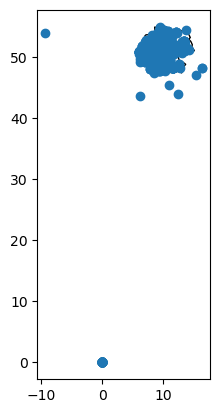

In [135]:
# import package
import geopandas as gpd

# create GeoDataFrame 
df_ger_geo = gpd.GeoDataFrame(
    df_ger, geometry = gpd.points_from_xy(df_ger.longitude,df_ger.latitude)
)

# create visualization based on the given code
# get a base map of Germany
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# create plot 
map = map[map.name == "Germany"].plot(color = "white", edgecolor = "black")
# plot the map with dots for the venues
df_ger_geo.plot(ax = map)


In [127]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
cities


,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Lobamba,POINT (31.20000 -26.46667)
4,Luxembourg,POINT (6.13000 49.61166)
...,...,...
238,Rio de Janeiro,POINT (-43.21212 -22.90731)
239,São Paulo,POINT (-46.62697 -23.55673)
240,Sydney,POINT (151.21255 -33.87137)
241,Singapore,POINT (103.85387 1.29498)


### (11)

<AxesSubplot:>

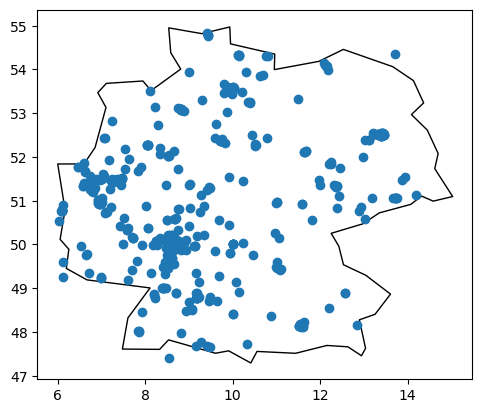

In [137]:
# write a function to adjust the longitude / latitude
# if these values aren't within the specific range for the country -> coded as NA
def adjust_long_lat(df,long_low,long_up,lat_low,lat_up):
    df.loc[df["longitude"] <long_low, "longitude"] = np.nan
    df.loc[df["longitude"] >long_up, "longitude"] = np.nan
    df.loc[df["latitude"] <lat_low, "latitude"] = np.nan
    df.loc[df["latitude"] >lat_up, "latitude"] = np.nan
    # return adjusted dataframe
    return df

# adjust the coordinates in case they outside of the longitude / latitude range
df_ger = adjust_long_lat(df_ger,5.866, 15.042, 47.270, 55.059)

# create GeoDataFrame 
df_ger_geo = gpd.GeoDataFrame(
    df_ger, geometry = gpd.points_from_xy(df_ger.longitude,df_ger.latitude)
)

# create visualization based on the given code
# get a base map of Germany
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# create plot 
map = map[map.name == "Germany"].plot(color = "white", edgecolor = "black")
# plot the map with dots for the venues
df_ger_geo.plot(ax = map)

### Event locations in other countries

### (12)

0
1
2
3
4
                           name             city postalCode  \
0                     Live Club            Milan      20056   
1                         ITALY  Gardone Riviera      25083   
2                         ITALY           Rubano      35030   
3                         ITALY             Rome      00187   
4                         ITALY           Modena      41121   
5                         ITALY           Rivoli      10098   
6                 Visarno Arena         Florence      50144   
7                        MISANO           MISANO      47843   
8  Autodrome Nazionale di Monza            Monza      20900   
9              Auditorium Cavea             Rome        196   

                                    address  \
0                  Via Giuseppe Mazzini, 58   
1                     Corso Zanardelli, 196   
2         via Liguria 1  Sarmeola di Rubano   
3                         Via del babuino 9   
4                             Via Stella 22   
5  Piazza Mafa

<AxesSubplot:>

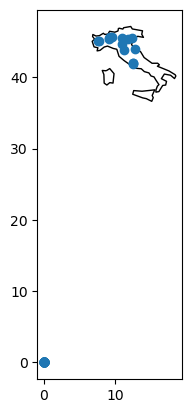

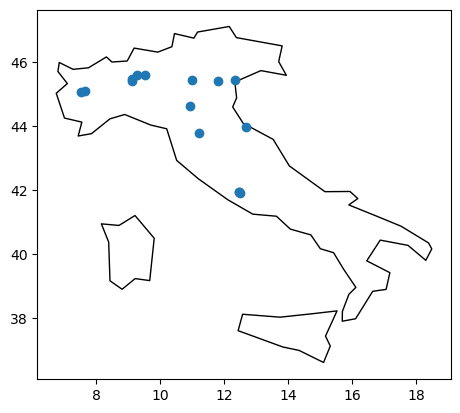

In [136]:
# create Dataframe for Italy
df_it = create_df("IT")

# print first 10 rows of Dataframe
print(df_it.head(10))

# print shape of dataframe
print(df_it.shape)


# create GeoDataFrame based on the
df_it_geo = gpd.GeoDataFrame(
    df_it, geometry = gpd.points_from_xy(df_it.longitude,df_it.latitude)
)

# create visualization based on the given code
# get a base map of Germany
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# create plot 
map = map[map.name == "Italy"].plot(color = "white", edgecolor = "black")
# plot the map with dots for the venues
df_it_geo.plot(ax = map)

# adjust the coordinates
# the extreme coordinates are for Italy
df_it = adjust_long_lat(df_it,6.616667, 18.516667, 37.933333, 47.083333)

# Updated version of the graph
# create GeoDataFrame based on the
df_it_geo = gpd.GeoDataFrame(
    df_it, geometry = gpd.points_from_xy(df_it.longitude,df_it.latitude)
)

# create visualization based on the given code
# get a base map of Germany
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# create plot 
map = map[map.name == "Italy"].plot(color = "white", edgecolor = "black")
# plot the map with dots for the venues
df_it_geo.plot(ax = map)